In [1]:
import numpy as np
import gym
import tensorflow as tf
import time
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, LeakyReLU, Input, Conv2D, MaxPool2D, Concatenate
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # stop displaying warnings that mean nothing!!!

PATH = './'

#### Initialising Tensorboard

In [2]:
# %load_ext tensorboard
# %tensorboard --logdir logs/fit
# # %tensorboard --logdir=data/ --host localhost --port 8888

## Run on Google Colab

In [3]:
# PATH = 'drive/MyDrive/MS/Opti/breakout/'

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# !python -m atari_py.import_roms /content/drive/MyDrive/MS/Opti/Roms/

## Initialising Environment

#### Pre-Processing Environment

In [6]:
def prepro(I):
    # preprocess each frame for learning
    # save some memory and computation
    # pre-process the image from a 210x160x3 uint8 frame into an (80x80) float array 
    I = I[::2,::2,0].copy()  
    I = I[47:-9,4:-5]
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return np.array(I)

def segment_env(I):
    I = prepro(I).copy()
    I_paddle = I[-1:,:]

    ball_miss = 1
    for i in range(1,I_paddle.shape[1]):
        if I_paddle[-1,i] == 0 and I_paddle[-1,i-1] == 1:
            ball_miss -= 1
    
    paddle_pos = np.mean(np.where(I_paddle == 1), axis = 1)
    paddle_pos[0] = I.shape[0]
    # print('Paddle',paddle_pos)
    
    I_ball = I[:-1,:]

    ball_pos = np.mean(np.where(I_ball == 1), axis = 1)
    ball_pos = np.nan_to_num(ball_pos, nan=0)
    
    delta = paddle_pos - ball_pos
    # print('Delta',delta)

    if (np.abs(delta[0]) <= 4) and (np.abs(delta[1]) <= 3):
        ball_miss = 5 # paddle hits the ball
    # print(delta)

    return I, delta, ball_miss

In [7]:

def plot_environment(I):
    fig, ax = plt.subplots(1, 2, figsize=(10, 10), sharex= False, sharey= False)
    ax[0].imshow(I)

    prep_im, _, _ = segment_env(I)
    ax[1].imshow(prep_im, cmap='gray')
    plt.show()

#### Initialising Environment Variables

Miss [49.         49.55555556]


/Users/rchaks/opt/miniforge3/envs/m1_tf/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/rchaks/opt/miniforge3/envs/m1_tf/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


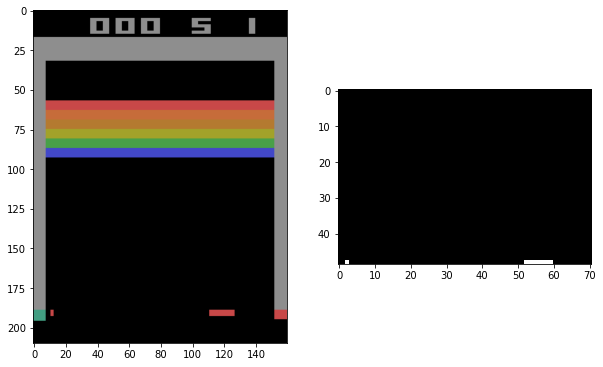

Hit [3.5 2. ]


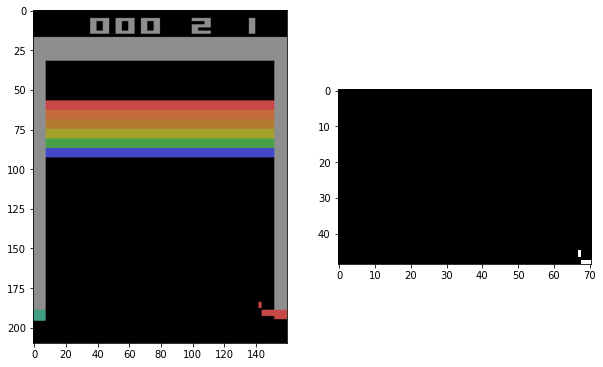

Hit [3.5 2. ]


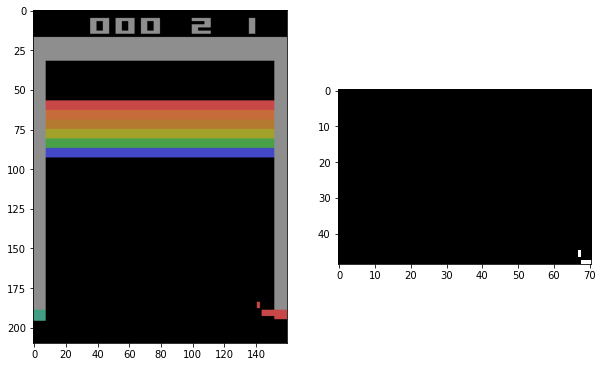

(49, 71)


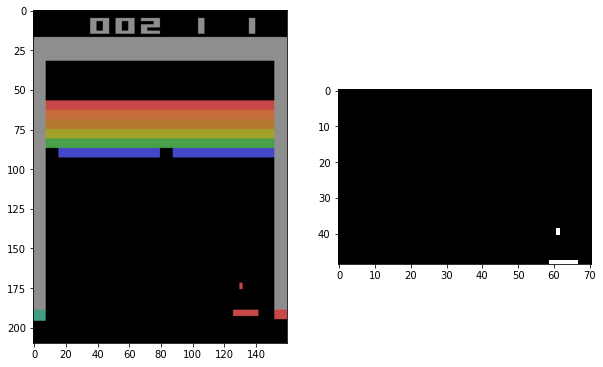

['NOOP', 'FIRE', 'RIGHT', 'LEFT']


In [8]:
frames_to_net = 1
frames_this_game = 0

env = gym.make("BreakoutDeterministic-v0")

pix = env.reset()
for i in range(200):
    pix, reward, done, info = env.step(env.action_space.sample()) # take a random action
    # env.render()
    # time.sleep(0.01)
    rew = segment_env(pix)
    if  rew[2] < 0:
        print('Miss',rew[1])
        plot_environment(pix)
    if rew[2] == 5:
        print('Hit',rew[1])
        plot_environment(pix)

board_dimensions = segment_env(pix)[0].shape

env.reset()
env.close()

print(board_dimensions)

plot_environment(pix)

action_space = env.action_space.n
print(env.unwrapped.get_action_meanings())
del env

## Policy Gradient with linear annealing, memory buffer, and same action for 4 consecutive frames

In [9]:
def discount_rewards(r):
    delt = 0.99 # discount factor
    nr = len(r)
    # we want to change all those zeros into discounted values of the next reward (this is the value function!)
    discounted_r = [0.0]*nr
    
    for t in range(nr):
        # start at the end
        if r[nr-t-1] > 0: # if you won a point in this frame we want a good reward
            discounted_r[nr-t-1] = r[nr-t-1]
        elif r[nr-t-1] < 0: # if we lost the point we want a bad reward
            discounted_r[nr-t-1] = -1
        elif t==0: # this is just for error catching...at t==0 r[nr-t-1] should have already been + or -...
            discounted_r[nr-t-1] = 0
        elif discounted_r[nr-t-1] == 0: # otherwise you want to look at the next reward value and discount it
            discounted_r[nr-t-1] = delt*discounted_r[nr-t]
    return discounted_r

In [10]:
frames_to_net = 4              # how many previous frames will we feed the NN
possible_actions = [x for x in range(5)] # the possible actions we can take

## Play a game

In [26]:
def play1game(model, ep = 0, render=False, slow= 0.01):
    env0 = gym.make("BreakoutDeterministic-v0")
    pix = env0.reset()
    pix, delta, ball_miss = segment_env(pix)

    dimensions = pix.shape

    action_space = env0.unwrapped.action_space.n
    
    frames_this_game = 0
    feed = np.zeros((1, dimensions[0], dimensions[1],frames_to_net))
    feed[0,:,:,0] = pix.copy()
    
    delta_feed = np.zeros((1,1,2, frames_to_net))
    delta_feed[0,:,:,0] = delta.copy()
    
    
    frame_array = []
    delta_array = []
    action_array = []
    reward_array = []
    
    score = 0
    action = 0
    done = False
    # try:
    while not done:
        if render == True: # do you actually want to visualize the playing?
            env0.render()
            time.sleep(slow)
        
        # skipping every 4 frames
        if frames_this_game%4 == 0:
            # epsilon-greedy
            if np.random.random() < ep:
                action = np.random.choice(action_space + 2)
            else:
                # vf = model(delta_feed, training=False).numpy()[0]
                vf = model([feed, delta_feed ],training=False).numpy()[0]
                action = np.random.choice(action_space,p=vf) + 2 # add 2 to the action to get the correct action

        if np.sum(pix[:-1,:]) == 0:
            action = 1 # Fire
        pix_new, reward, done, info = env0.step(action)
        pix, delta, ball_miss = segment_env(pix_new)

        if ball_miss < 0:
            reward = -1
        elif ball_miss == 5:
            reward = 1

        frame_array.append(pix)
        action_array.append(action)
        reward_array.append(reward)
        delta_array.append(delta)
        frames_this_game += 1

        for f in range(1,frames_to_net):
            feed[0,:,:,frames_to_net-f] = feed[0,:,:,frames_to_net-f-1].copy()
        feed[0,:,:,0] = pix.copy()
        score += reward

        if frames_this_game > 50000:#5000000:
            print("Game is taking too long, breaking")
            done = True
            break
    
    # except Exception as e:
    #     print(e)
    # except KeyboardInterrupt:
    #     print('KeyboardInterrupt')
    # finally:
    env0.reset()
    env0.close()
        
    return frame_array, delta_array, action_array, reward_array, score

## Creating CNN

#### Define a Neural Network

In [27]:
def create_model(height,width,channels, action_space):
    imp = Input(shape=(height,width,channels))
    mid = Conv2D(32,(2,2),strides=4,activation='relu')(imp)
    mid = MaxPool2D(pool_size = (2,2))(mid)
    
    mid = Conv2D(64,(2,2),strides=2,activation='relu')(mid)
    mid = MaxPool2D(pool_size = (2,2))(mid)
    mid = Flatten()(mid)

    numeric_imp = Input(shape=(1, 2,channels))
    numeric_mid = Dense(2,activation='relu')(numeric_imp)
    numeric_mid = LeakyReLU(alpha=0.01)(numeric_mid)
    numeric_mid = Flatten()(numeric_mid)

    mid = Concatenate()([mid,numeric_mid])
    
    mid = Dense(4,activation='relu')(mid)
    mid = LeakyReLU(alpha=0.01)(mid)
    out0 = Dense(action_space,activation='softmax', name = 'output')(mid)
    model = Model([imp, numeric_imp],out0) 
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),loss='sparse_categorical_crossentropy')
    
    return model

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 49, 71, 4)]  0           []                               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 12, 18, 32)   544         ['input_5[0][0]']                
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 6, 9, 32)    0           ['conv2d_4[0][0]']               
                                                                                                  
 input_6 (InputLayer)           [(None, 1, 2, 4)]    0           []                               
                                                                                            

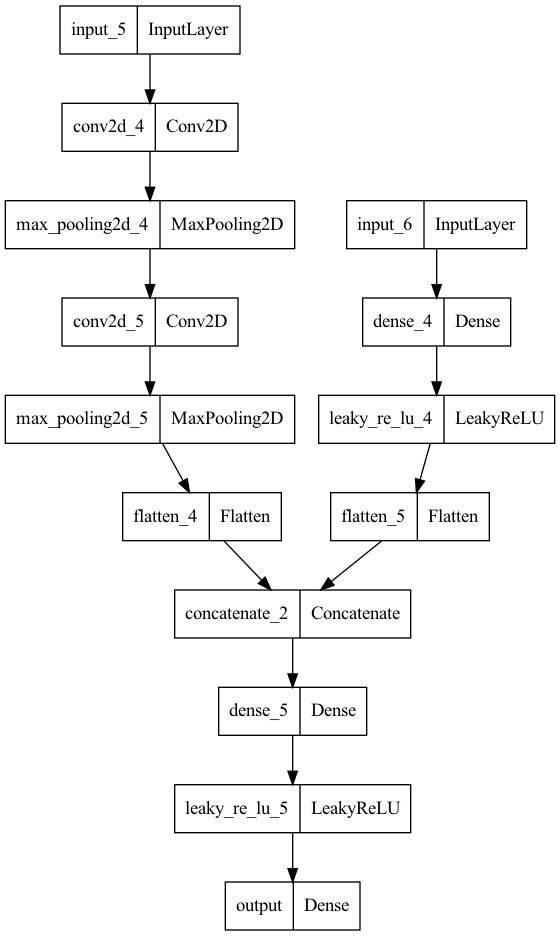

In [28]:
mod = create_model(
                height = board_dimensions[0],
                width = board_dimensions[1],
                channels = frames_to_net, 
                action_space = action_space -2 # the -2 is because we don't want to fire or No-Op
            )
mod.call = tf.function(mod.call,experimental_relax_shapes=True)

mod.summary()

tf.keras.utils.plot_model(mod)

#### Load pre-trained model from file

In [29]:
model_name = 'breakout_deterministic_dump'

In [30]:
# mod = tf.keras.models.load_model(PATH+f'weights/{model_name}.h5')
# mod.call = tf.function(mod.call,experimental_relax_shapes=True)

# mod.summary()

# model_name = 'breakout_deterministic'

## Training

In [31]:
epsvec = np.linspace(1,0.05,500)
tgames = 10 # training games
ngames = 200 # games played after training
nbatch = 10
buffn = 200000
warmupgames = 5
len_buff = 0
buffer = {'frames':[], 'deltas':[],'actions':[],'rewards':[]}

In [32]:
game = 0
scores = []

In [33]:
import sys
pbar = tqdm(total=tgames)

with open(PATH+f'scores_{model_name}.csv','a') as out_file:
    out_file.write('game,score, train_time, len_buff, timestamp\n')

    while True:
        pbar.update(1)
        start = time.time()
        g = min(game, tgames-1)
        epsilon = epsvec[g] if g < 500 else 0
        frames, deltas, actions, rewards, score = play1game(mod, epsilon)
        
        rewards = discount_rewards(rewards.copy())
        # memory buffer
        buffer['frames'] += frames.copy()
        buffer['deltas'] += deltas.copy()
        buffer['actions'] += actions.copy()
        buffer['rewards'] += rewards.copy()
        len_buff += len(actions)

        if len_buff > buffn:
            excess = len_buff - buffn
            buffer['frames'] = buffer['frames'][excess:].copy()
            buffer['deltas'] = buffer['deltas'][excess:].copy()
            buffer['actions'] = buffer['actions'][excess:].copy()
            buffer['rewards'] = buffer['rewards'][excess:].copy()
            len_buff = len(buffer['actions'])
        rewards = np.array(rewards)
        actions = np.array(actions)
        nframes = len(frames)

        current_frames = np.zeros((nframes, board_dimensions[0], board_dimensions[1],frames_to_net))
        current_deltas = np.zeros((nframes, 1, 2, frames_to_net))
        
        if game >= warmupgames:
            prob = np.ones(len_buff)
            prob[np.array(buffer['rewards']) > 0] = 5.0
            print(prob)
            prob /= np.sum(prob)
            which_choose = np.random.choice(len_buff,size=nframes,replace=False,p=prob)
        
            for grab in range(nframes):
                rewards[grab] = buffer['rewards'][which_choose[grab]]
                actions[grab] = buffer['actions'][which_choose[grab]]
                for f in range(frames_to_net):
                    if grab-f > 0:
                        current_frames[grab,:,:,f] = buffer['frames'][which_choose[grab]-f].copy()
                        current_deltas[grab,:,:,f] = buffer['deltas'][which_choose[grab]-f].copy()
            
            # history = mod.fit(current_deltas, actions,epochs=1,steps_per_epoch=nbatch,verbose=0,sample_weight=rewards,use_multiprocessing=True)
            history = mod.fit([current_frames, current_deltas],actions,epochs=1,steps_per_epoch=nbatch,verbose=0,sample_weight=rewards,use_multiprocessing=True)
        stop = time.time()
        
        game += 1
        # too many games to train on, hard stop
        if game >= tgames:
            break
        # append consecutive positive scores
        if score > 0:
            scores.append(score)
        elif len(scores) > 0:
            scores.pop(0)
        else:
            pass
        t = time.localtime()
        out_file.write(str(game)+','+str(score)+','+str(round(stop-start, 4))+','+str(len_buff)+'\n')
        out_file.flush()


        mod.save(PATH+f'weights/{model_name}.h5')
        
        if (game)%100 == 1:
          time.sleep(0.01) # allow changes to reflect on drive
        sys.stdout.flush()
        if len(scores) > tgames:
            break

 60%|██████    | 6/10 [01:15<00:50, 12.57s/it]
/Users/rchaks/opt/miniforge3/envs/m1_tf/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/rchaks/opt/miniforge3/envs/m1_tf/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


IndexError: index 4 is out of bounds for axis 0 with size 4

## Analysis of Training

In [34]:
import pandas as pd

df = pd.read_csv(PATH+f'scores_{model_name}.csv')[['score','train_time']]
df

KeyError: "['train_time'] not in index"

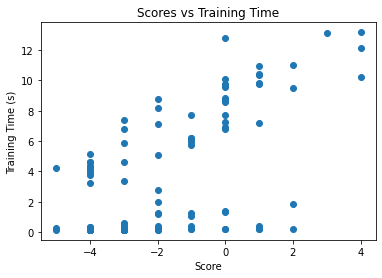

In [ ]:
from matplotlib import pyplot as plt

plt.scatter(df['score'], df['train_time'])
plt.ylabel('Training Time (s)')
plt.xlabel('Score')
plt.title('Scores vs Training Time')
plt.show()

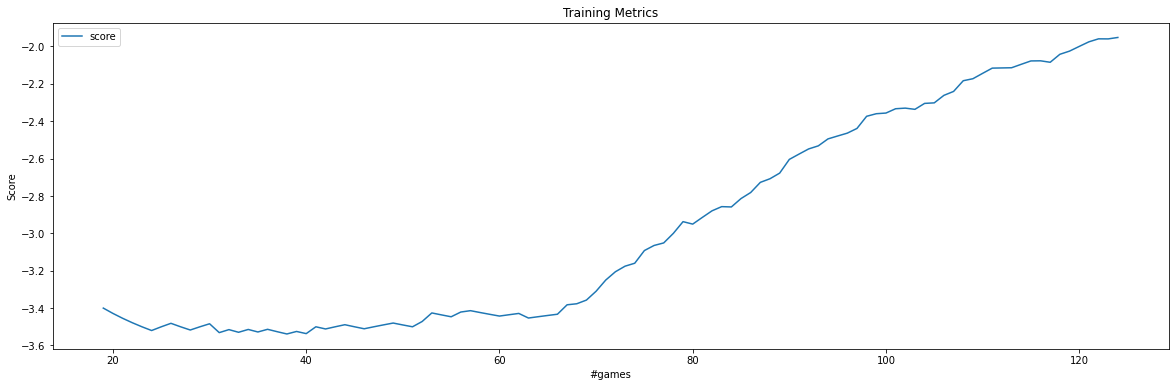

In [ ]:
window = 150
min_periods = 20
plt.figure(figsize=(20, 6))
# df['score'][min_periods:].plot(alpha = 0.3)
x = df['score'].rolling(window= window, min_periods = min_periods).mean().dropna()
x.plot()
line = np.linspace(0, x.shape[0], x.shape[0])
# plt.plot(np.log10(line)*25+450, linestyle = 'dotted', linewidth = '0.7', label = 'learning curve', color = 'red')
plt.ylabel('Score')
plt.xlabel('#games')
plt.title('Training Metrics')
plt.legend()

## Visualise the game after training

#### Loading the game

In [ ]:
mod2 = tf.keras.models.load_model(PATH+f'weights/{model_name}.h5')
mod2.call = tf.function(mod2.call,experimental_relax_shapes=True)

mod2.summary()

Model: "dual_input_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 board_input (InputLayer)       [(None, 36, 80, 4)]  0           []                               
                                                                                                  
 conv1 (Conv2D)                 (None, 17, 39, 32)   2080        ['board_input[0][0]']            
                                                                                                  
 health_input (InputLayer)      [(None, 1, 2, 4)]    0           []                               
                                                                                                  
 conv2 (Conv2D)                 (None, 4, 9, 16)     12816       ['conv1[0][0]']                  
                                                                                   

567.0


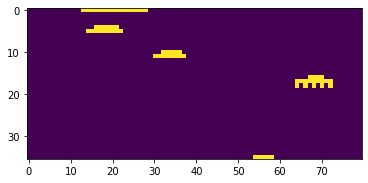

In [ ]:
frame_array, health_array, action_array, reward_array, score = play1game(mod2)

plt.imshow(frame_array[-1])
print(score)

#### Simulations

In [ ]:
ngames = 500
scores = np.zeros(ngames)

with open(PATH+'game_scores.csv','a') as f:
  for game in tqdm(range(ngames)):
      frames, health, actions, rewards, score = play1game(mod2, 0)
      scores[game] = score
      f.write(str(score)+'\n')
      f.flush()
np.mean(scores)

100%|██████████| 500/500 [50:22<00:00,  6.05s/it]


526.26

#### Visualising model Performance

In [ ]:
import pandas as pd

scores = pd.read_csv(PATH+'game_scores.csv')['game']
scores

0      630.0
1      336.0
2      672.0
3      441.0
4      483.0
       ...  
995    420.0
996    357.0
997    567.0
998    651.0
999    735.0
Name: game, Length: 1000, dtype: float64

In [ ]:
print('Mean:', scores.mean())
print('Mode:', scores.mode()[0])
print('Median:', scores.median())
print('Std Dev:', round(scores.std(),2))
print('Skew:', round(scores.skew(),2))

Mean: 534.933
Mode: 651.0
Median: 588.0
Std Dev: 137.83
Skew: -0.87


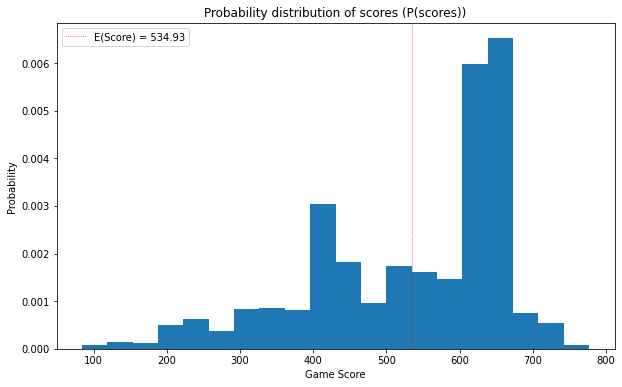

In [ ]:
import pandas as pd
plt.figure(figsize = (10,6))
plt.hist(scores, bins = 20, density = True)
plt.axvline(x=scores.mean(), linewidth = 0.7, linestyle = 'dotted', color = 'red', label = f'E(Score) = {np.round(scores.mean(),2)}')
plt.xlabel('Game Score')
plt.ylabel('Probability')
plt.title('Probability distribution of scores (P(scores))')
plt.legend()

***
